# Snake

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from environments_fully_observable import OriginalSnakeEnvironment
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from agents import BaselineAgent, RandomAgent, DQNAgent, HybridDQNAgent
from collections import deque
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

## Environment definition

In [8]:
def plot_board(boards, how_many=5):
    num_boards = min(len(boards), how_many)
    
    # If only one board is passed, axs should not be an array
    if num_boards == 1:
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.imshow(boards[0], origin="lower")
    else:
        fig, axs = plt.subplots(1, num_boards, figsize=(10, 3))
        for ax, board in zip(axs, boards[:num_boards]):
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            ax.imshow(board, origin="lower")

    plt.show()


## All agents training

In [11]:
MOVES_PER_GAME = 1000
NUM_BOARDS = 1000
BOARD_SIZE = 7
ITERS = 10
BATCH_SIZE = 50  # Learn at steps of 40

## Testing

In [12]:
tf.keras.utils.disable_interactive_logging()

rnd_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)
base_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)
dqn_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)
hybrid_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)

rnd_agent = RandomAgent()
baseline_agent = BaselineAgent()
dqn_agent = DQNAgent(dqn_env.boards)
hybrid_agent = HybridDQNAgent(hybrid_env.boards)

rnd_rewards = []
baseline_rewards = []
dqn_rewards = []
hybrid_rewards = []

for _ in trange(MOVES_PER_GAME):
    # Get actions from the agents
    rnd_actions = rnd_agent.get_actions(rnd_env.boards)
    base_actions = baseline_agent.get_actions(base_env.boards)
    dqn_actions = dqn_agent.get_actions(dqn_env.boards)
    hybrid_actions = hybrid_agent.get_actions(hybrid_env.boards)

    dqn_prev_boards = dqn_env.boards.copy()
    hybrid_prev_boards = hybrid_env.boards.copy()
    
    # Perform the actions and get the rewards from the environment
    rnd_reward = rnd_env.move(rnd_actions)
    baseline_reward = base_env.move(base_actions)
    dqn_reward = dqn_env.move(dqn_actions)
    hybrid_reward = hybrid_env.move(hybrid_actions)

    # Learn from it
    dqn_agent.learn(dqn_prev_boards, dqn_actions, dqn_reward, dqn_env.boards)
    hybrid_agent.learn(hybrid_prev_boards, hybrid_actions, hybrid_reward, hybrid_env.boards)

    
    # Store the rewards for each move
    rnd_rewards.append(np.mean(rnd_reward))
    baseline_rewards.append(np.mean(baseline_reward))
    dqn_rewards.append(np.mean(dqn_reward))
    hybrid_rewards.append(np.mean(hybrid_reward))

100%|██████████| 100/100 [04:21<00:00,  2.61s/it]


In [37]:
tf.keras.utils.disable_interactive_logging()
rnd_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)
base_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)
dqn_env = OriginalSnakeEnvironment(NUM_BOARDS, BOARD_SIZE)
rnd_agent = RandomAgent()
baseline_agent = BaselineAgent()
dqn_agent = DQNAgent(dqn_env.boards)

# Create a replay buffer
replay_buffer = deque(maxlen=1000)  # Adjust the size as needed
rnd_rewards = []
baseline_rewards = []
dqn_rewards = []

for _ in trange(MOVES_PER_GAME):
    # Get actions from the agents
    rnd_actions = rnd_agent.get_actions(rnd_env.boards)
    base_actions = baseline_agent.get_actions(base_env.boards)
    dqn_actions = dqn_agent.get_actions(dqn_env.boards)
    
    prev_boards = dqn_env.boards.copy()
    
    # Perform the actions and get the rewards from the environment
    rnd_reward = rnd_env.move(rnd_actions)
    baseline_reward = base_env.move(base_actions)
    dqn_reward = dqn_env.move(dqn_actions)
    
    # Store the experiences in the replay buffer
    replay_buffer.extend(zip(prev_boards, dqn_actions, dqn_reward, dqn_env.boards.copy()))
    
    # Prepare current experience
    current_experience = (prev_boards, dqn_actions, dqn_reward, dqn_env.boards)
    
    # Learn from combined current experience and replay buffer
    if len(replay_buffer) >= 100:
        minibatch = random.sample(replay_buffer, 100)
        buffer_states, buffer_actions, buffer_rewards, buffer_next_states = zip(*minibatch)
        
        # Combine current experience with buffer samples
        combined_states = np.concatenate([np.array(buffer_states), current_experience[0]])
        combined_actions = np.concatenate([np.array(buffer_actions), current_experience[1]])
        combined_rewards = np.concatenate([np.array(buffer_rewards), current_experience[2]])
        combined_next_states = np.concatenate([np.array(buffer_next_states), current_experience[3]])
        
        dqn_agent.learn(combined_states, combined_actions, combined_rewards, combined_next_states)
    else:
        # Learn from current experience only
        dqn_agent.learn(prev_boards, dqn_actions, dqn_reward, dqn_env.boards)
    
    # Store the rewards for each move
    rnd_rewards.append(np.mean(rnd_reward))
    baseline_rewards.append(np.mean(baseline_reward))
    dqn_rewards.append(np.mean(dqn_reward))

/home/gp-1108/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
100%|██████████| 1000/1000 [14:55<00:00,  1.12it/s]


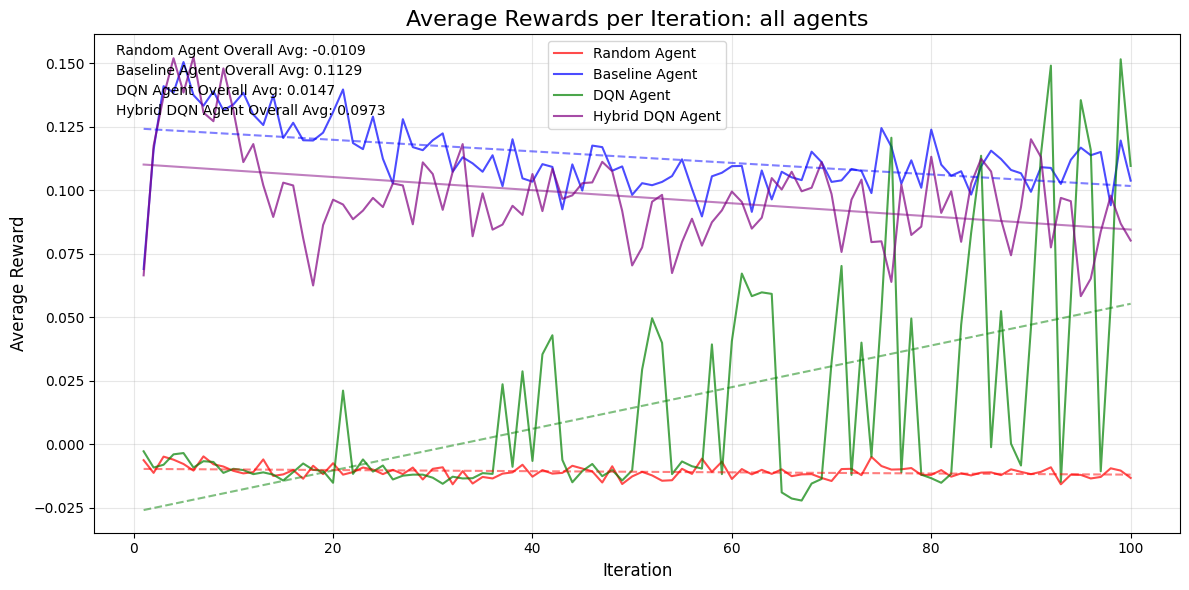

In [13]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, MOVES_PER_GAME + 1), rnd_rewards, label='Random Agent', color='red', alpha=0.7)
plt.plot(range(1, MOVES_PER_GAME + 1), baseline_rewards, label='Baseline Agent', color='blue', alpha=0.7)
plt.plot(range(1, MOVES_PER_GAME + 1), dqn_rewards, label='DQN Agent', color='green', alpha=0.7)
plt.plot(range(1, MOVES_PER_GAME + 1), hybrid_rewards, label='Hybrid DQN Agent', color='purple', alpha=0.7)

# Add a trend line for each agent
z_rnd = np.polyfit(range(1, MOVES_PER_GAME + 1), rnd_rewards, 1)
p_rnd = np.poly1d(z_rnd)
plt.plot(range(1, MOVES_PER_GAME + 1), p_rnd(range(1, MOVES_PER_GAME + 1)), "r--", alpha=0.5)

z_base = np.polyfit(range(1, MOVES_PER_GAME + 1), baseline_rewards, 1)
p_base = np.poly1d(z_base)
plt.plot(range(1, MOVES_PER_GAME + 1), p_base(range(1, MOVES_PER_GAME + 1)), "b--", alpha=0.5)

z_dqn = np.polyfit(range(1, MOVES_PER_GAME + 1), dqn_rewards, 1)
p_dqn = np.poly1d(z_dqn)
plt.plot(range(1, MOVES_PER_GAME + 1), p_dqn(range(1, MOVES_PER_GAME + 1)), "g--", alpha=0.5)

z_hybrid = np.polyfit(range(1, MOVES_PER_GAME + 1), hybrid_rewards, 1)
p_hybrid = np.poly1d(z_hybrid)
plt.plot(range(1, MOVES_PER_GAME + 1), p_hybrid(range(1, MOVES_PER_GAME + 1)), "purple", alpha=0.5)

# Customize the plot
plt.title('Average Rewards per Iteration: all agents', fontsize=16)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add text with overall average rewards
plt.text(0.02, 0.98, f"Random Agent Overall Avg: {np.mean(rnd_rewards):.4f}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.94, f"Baseline Agent Overall Avg: {np.mean(baseline_rewards):.4f}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.90, f"DQN Agent Overall Avg: {np.mean(dqn_rewards):.4f}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.86, f"Hybrid DQN Agent Overall Avg: {np.mean(hybrid_rewards):.4f}",
            transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# Show the plot
plt.tight_layout()
plt.show()

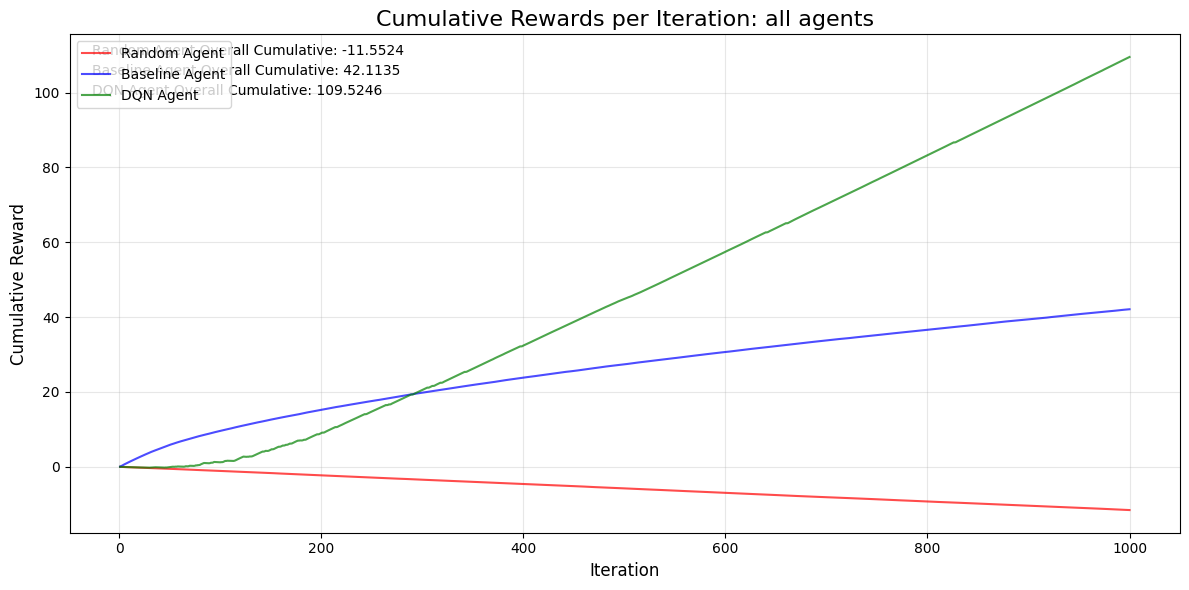

In [39]:
# Now plot the cumulative rewards
plt.figure(figsize=(12, 6))
plt.plot(range(1, MOVES_PER_GAME + 1), np.cumsum(rnd_rewards), label='Random Agent', color='red', alpha=0.7)
plt.plot(range(1, MOVES_PER_GAME + 1), np.cumsum(baseline_rewards), label='Baseline Agent', color='blue', alpha=0.7)
plt.plot(range(1, MOVES_PER_GAME + 1), np.cumsum(dqn_rewards), label='DQN Agent', color='green', alpha=0.7)
plt.plot(range(1, MOVES_PER_GAME + 1), np.cumsum(hybrid_rewards), label='Hybrid DQN Agent', color='purple', alpha=0.7)

# Customize the plot
plt.title('Cumulative Rewards per Iteration: all agents', fontsize=16)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cumulative Reward', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add text with overall cumulative rewards
plt.text(0.02, 0.98, f"Random Agent Overall Cumulative: {np.sum(rnd_rewards):.4f}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.94, f"Baseline Agent Overall Cumulative: {np.sum(baseline_rewards):.4f}",
            transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.90, f"DQN Agent Overall Cumulative: {np.sum(dqn_rewards):.4f}",
            transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.86, f"Hybrid DQN Agent Overall Cumulative: {np.sum(hybrid_rewards):.4f}",
            transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# Show the plot
plt.tight_layout()
plt.show()

In [40]:
# Saving the model
dqn_model = dqn_agent.model
dqn_model.save_weights("dqn_model.weights.h5")
hybrid_model = hybrid_agent.model
hybrid_model.save_weights("hybrid_model.weights.h5")

In [20]:
# Disable interactive logging
tf.keras.utils.disable_interactive_logging()

# Initialize environments and agents
base_env = OriginalSnakeEnvironment(1000, BOARD_SIZE)
dqn_env = OriginalSnakeEnvironment(1000, BOARD_SIZE)

dqn_agent_test = DQNAgent(dqn_env.boards)
dqn_agent_test.model.load_weights("dqn_model.weights.h5")
baseline_agent_test = BaselineAgent()

# Initialize variables for tracking fruits eaten
dqn_fruits_list = []
baseline_fruits_list = []

dqn_wall_hits = []
baseline_wall_hits = []

dqn_fruits = 0
baseline_fruits = 0

dqn_wall = 0
baseline_wall = 0

# Perform 1000 iterations
for step in trange(1000):
    # Get actions from the agents
    dqn_actions = dqn_agent_test.get_actions(dqn_env.boards)
    baseline_actions = baseline_agent_test.get_actions(base_env.boards)
    
    # Perform the actions and get the rewards from the environment
    dqn_reward = dqn_env.move(dqn_actions)
    baseline_reward = base_env.move(baseline_actions)
    
    # The fruit reward is 0.5, count the number of fruits eaten
    dqn_fruits += np.sum(dqn_reward == 0.5)
    baseline_fruits += np.sum(baseline_reward == 0.5)

    # The wall hit reward is -0.1, count the number of wall hits
    dqn_wall += np.sum(dqn_reward == -0.1)
    baseline_wall += np.sum(baseline_reward == -0.1)
    
    # Every 10 steps, save the current number of fruits eaten
    if (step + 1) % 10 == 0:
        dqn_fruits_list.append(dqn_fruits)
        baseline_fruits_list.append(baseline_fruits)

        dqn_wall_hits.append(dqn_wall)
        baseline_wall_hits.append(baseline_wall)

100%|██████████| 1000/1000 [03:28<00:00,  4.80it/s]


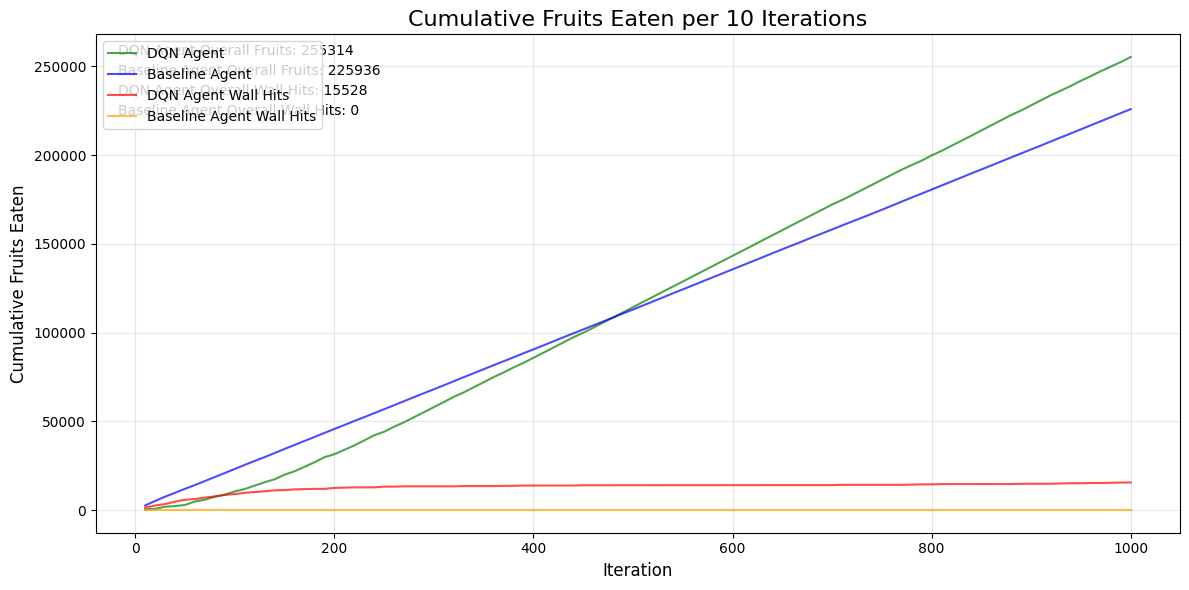

In [21]:
# Plot the cumulative fruits eaten
plt.figure(figsize=(12, 6))
plt.plot(range(10, 1001, 10), dqn_fruits_list, label='DQN Agent', color='green', alpha=0.7)
plt.plot(range(10, 1001, 10), baseline_fruits_list, label='Baseline Agent', color='blue', alpha=0.7)
plt.plot(range(10, 1001, 10), dqn_wall_hits, label='DQN Agent Wall Hits', color='red', alpha=0.7)
plt.plot(range(10, 1001, 10), baseline_wall_hits, label='Baseline Agent Wall Hits', color='orange', alpha=0.7)

# Customize the plot
plt.title('Cumulative Fruits Eaten per 10 Iterations', fontsize=16)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cumulative Fruits Eaten', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add text with overall cumulative fruits eaten
plt.text(0.02, 0.98, f"DQN Agent Overall Fruits: {dqn_fruits}", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.94, f"Baseline Agent Overall Fruits: {baseline_fruits}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.90, f"DQN Agent Overall Wall Hits: {dqn_wall}",
            transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.02, 0.86, f"Baseline Agent Overall Wall Hits: {baseline_wall}",
            transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# Show the plot
plt.tight_layout()
plt.show()